# Assignment II - Object detection using Deep Learning

### Including the Appropriate Libraries

In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np

## 1. Use Case Definition: 

#### Real-world use case for object detection. = `Construction Safety and prevention of Traumatic Brain Injury(TBI)`

The [Bureau of Labor Statistics (USA)](https://blogs.cdc.gov/niosh-science-blog/2022/11/10/construction-helmets/) outlines the following in relation to TBI:

"The construction industry has the greatest number of both fatal and nonfatal WR(work-related) TBI among U.S. workplaces. From 2003 to 2010, 2,210 construction workers died because of a TBI (a rate of 2.6 per 100,000 full time equivalent workers). These deaths represented 25% of all construction fatalities and 24% of all WR TBI fatalities among all industries during that period."

This means that ensuring that people are protected at all times from any and all potential threats of TBI should be extremely important, and thus present the opportunity of using YOLO to try and detect if people are wearing or not wearing their helmets



## 2. Data Collection: 
- Used Roboflow for the dataset [Link](https://universe.roboflow.com/joseph-nelson/hard-hat-workers)
- Images were already annotated with bounding boxes

In [18]:
# Checking that Cuda (and therefore my GPU is available)
torch.cuda.is_available()

True

## 3. Data Preprocessing: 

- Preprocess the dataset by 
    - Resizing images = YOLO can already autoresize the images in the picture given the size we specify in the call of the function. This is done with padding if the images are bigger or rescaling and padding them if smaller.
    - Normalizing pixel values = Yolo already does this (it seems this algorithm does anything and everything for us :) 
    - Splitting it into training, validation, and test sets. (Roboflow already does this for us) 

### Addressing Class Imbalance
- Before going through the data, I decided that I would 'ignore/delete' the person class given there was such a little amount of labels in the data, and as such it would make no sense to train the model on it.
    - As such, it made most sense to forget about this label and train the model on the most relevant classes, this is also ok since detecting a "head" will essentially give us the same result we want which is detecting a person.

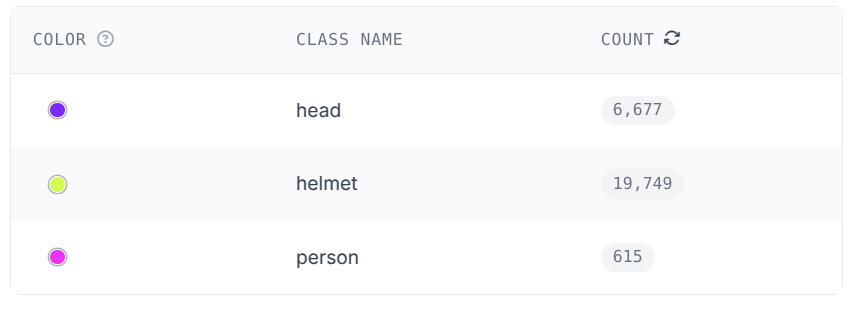

I used Roboflow's `Modify Classes` to delete the images from the `original` dataset (this was much easier than what I saw I needed to do if I wanted to drop the labels within python)


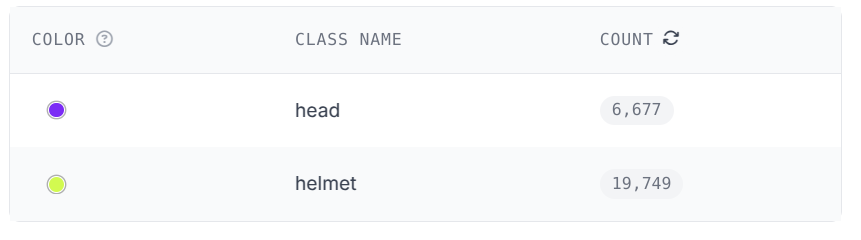

### Image Resizing  
- Roboflow gives us useful analytics (I know I can or should make plots like this in the long run for myself), and it shows that the majority of our images follow this distribution. `The dashed lines represent the median width (500 px) and median height (333 px) of images in your dataset.`

- As such we should try to pass a image size parameter so that most images can pass through without needing to be significantly resized to unecessary dimensions.



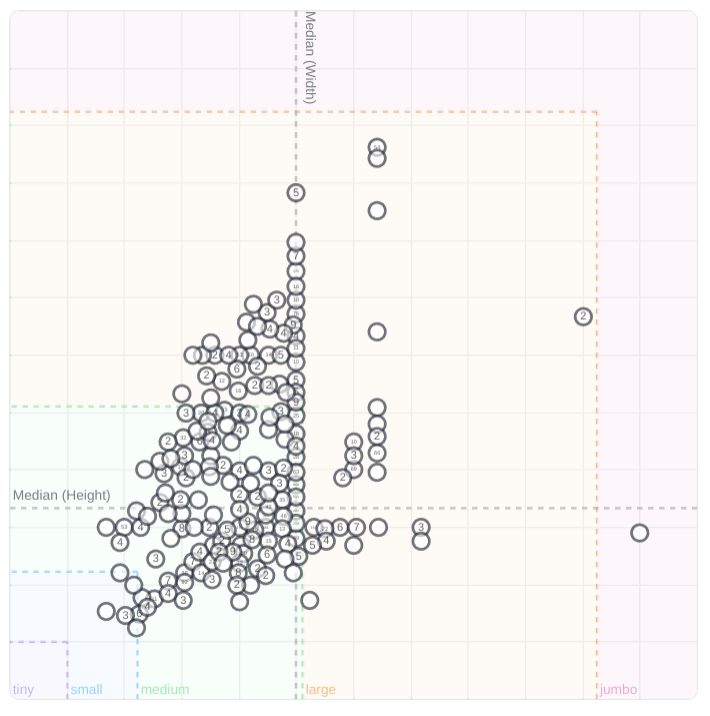

## 4. YOLO fine-tuning: 

- Leverage the YOLO algorithm using one of the solutions 
already implemented in GitHub. 

- Fine-tune the YOLO model using the training dataset for optimal object detection performance. 

Here we will set the following parameters:

Parameters | Description 
|---|----|
`!python yolov7/train.py` | Name of the model
`--img 550 400` | This is out Image resize parameter that we mentioned above, for now we can set it `'550 400'` to capture over 1/2 of the images, while adding in some extra buffer for the model to not resize unecessarily.       
`--batch 8` | This is just a recommended amount given my GPU Specs (Nvidia RTX 3070, 8GB)
`--epochs 10` | Given the Computational cost of this 10 epochs should be enough to prove modoel convergence to the data while not overfitting instead of running this on 100+ epochs
`--data images/hhyolov7/data.yaml` | Path to the data.yaml with annotations
`--weights yolov7/yolov7.pt` | Weights from another pretrained model (Transfer Learing), for better and faster results without having to retrain the model while also having lower risk of overfitting 
`--cache` | Here we cache the images so that they are not re-processes during each epoch after the first iteration. 
`--device 0` | Assigning (in a bad way) that these operations should be done on the GPU 
```

In [21]:
!python yolov7/train.py --img 550 400 --batch 8 --epochs 10 --data images/hhyolov7/data.yaml --weights yolov7/yolov7.pt --cache --device 0

YOLOR 🚀 v0.1-128-ga207844 torch 2.5.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7973.6875MB)

Namespace(weights='yolov7/yolov7.pt', cfg='', data='images/hhyolov7/data.yaml', hyp='./yolov7/data/hyp.scratch.p5.yaml', epochs=10, batch_size=8, img_size=[550, 400], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=True, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='exp', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', freeze=[0], v5_metric=False, world_size=1, global_rank=-1, save_dir='runs/train/exp7', total_batch_size=8)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_moment

Here we run NMS to ensure that we have the highest confidence in the chosen class, which is important given the important application of this model for injury prevention

In [23]:
!python yolov7/detect.py --weights runs/train/exp7/weights/best.pt --source images/hhyolov7/test/images/ --agnostic-nms

Namespace(weights=['runs/train/exp7/weights/best.pt'], source='images/hhyolov7/test/images/', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=True, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.5.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7973.6875MB)

/home/sebas/Desktop/ie_dev/y4.1/advancedAI/assignments/hw2-objectDetection/yolov7/models/experimental.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the fun

## 5. Model Evaluation: 

- Evaluate the trained YOLO model on the test dataset. 
- Calculate object detection metrics such as mean average precision (mAP) and IoU (Intersection over Union) to assess its performance. 

### Metrics with the Person Label:
- I had previously trained the data with the person label and the result was the Mean Average Precision Score (mAP), down to `0.664`, which means it was a good decision to ignore the label overall

```
Class      Images      Labels           P           R      mAP@.5           
all         1413        5353       0.957       0.632       0.664       0.442
head        1413        1339       0.919       0.941       0.961       0.635
helmet      1413        3913       0.951       0.954       0.986       0.663
person      1413         101           1           0       0.0457      0.028
```



### Current Metrics
- Given these results we can reliably detect if someone is or is not wearing a helmet and thus obtain a safe working environment!

- More technically we can see that the results are the following:

Metric | Interpretation
|-|-|
`F1-Score` |
`Recall` |
`Precision` |
`mAP`|

In [25]:
!python yolov7/test.py \
  --data images/hhyolov7/data.yaml \
  --weights runs/train/exp7/weights/best.pt \
  --img 550 --conf-thres 0.001 --iou-thres 0.65


Namespace(weights=['runs/train/exp7/weights/best.pt'], data='images/hhyolov7/data.yaml', batch_size=32, img_size=550, conf_thres=0.001, iou_thres=0.65, task='val', device='', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='exp', exist_ok=False, no_trace=False, v5_metric=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.5.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7973.6875MB)

/home/sebas/Desktop/ie_dev/y4.1/advancedAI/assignments/hw2-objectDetection/yolov7/models/experimental.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped 

### `Notice`
I acknoledge the use of ChatGPT4o to generate the code in the cell below mainly just to quickly show all the images that were already created from the YOLO Model. I believe these are a small part of the project and are mainly for representation purposes. The prompts include:

just plot these images: which the model already computed: (Then I added the name of the files which I wanted)

The output of the prompt was used to display the metrics of the model training and how it performed under the established circumstances

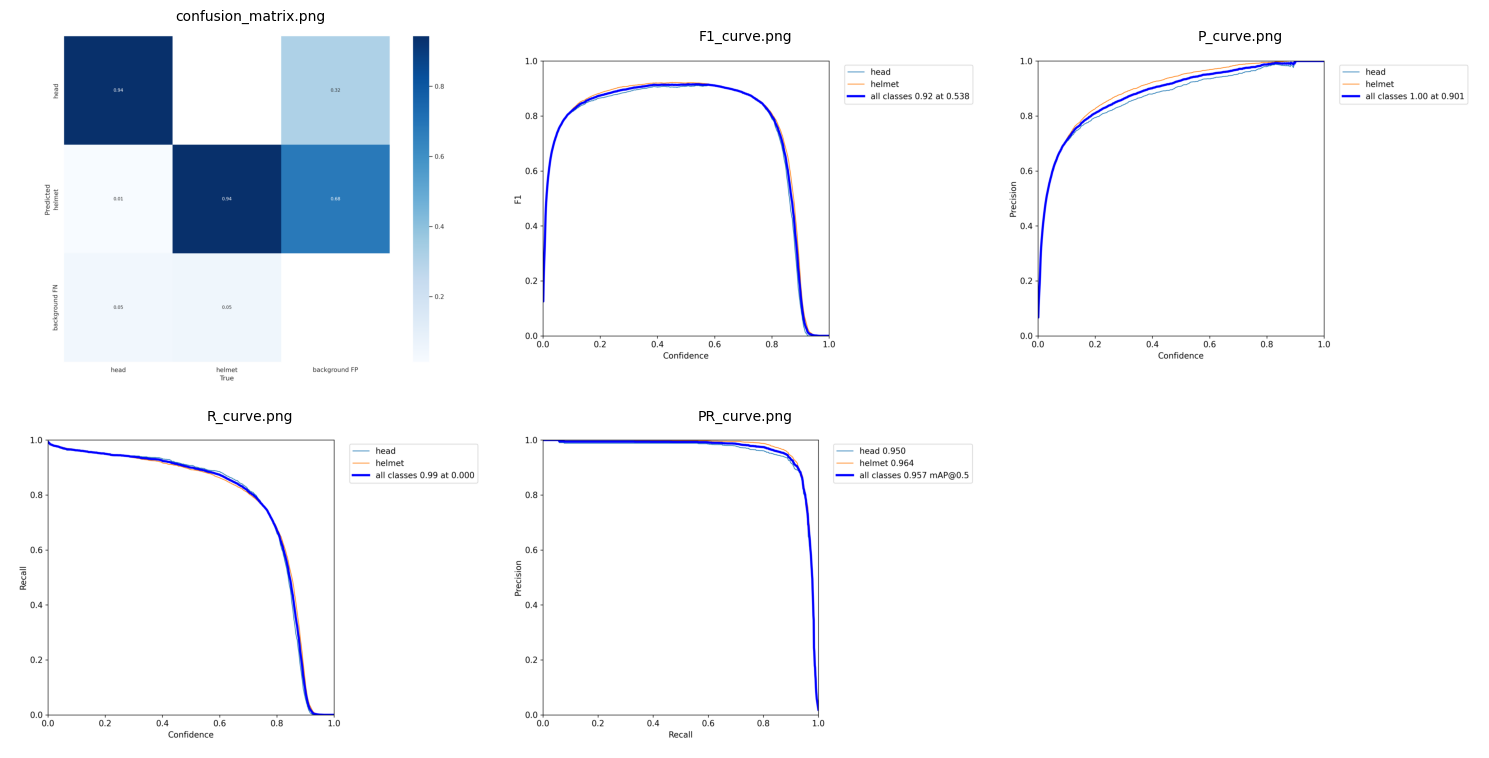

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 🔧 Change this path to your experiment folder
exp_dir = "runs/train/exp7"

# List of result images you want to display
image_paths = [
    f"{exp_dir}/confusion_matrix.png",
    f"{exp_dir}/F1_curve.png",
    f"{exp_dir}/P_curve.png",
    f"{exp_dir}/R_curve.png",
    f"{exp_dir}/PR_curve.png",
]


# inline grid layout
cols = 3
rows = (len(image_paths) + cols - 1) // cols
plt.figure(figsize=(15, 8))

for i, path in enumerate(image_paths, 1):
    img = mpimg.imread(path)
    ax = plt.subplot(rows, cols, i)
    ax.imshow(img)
    ax.set_title(path.split("/")[-1], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

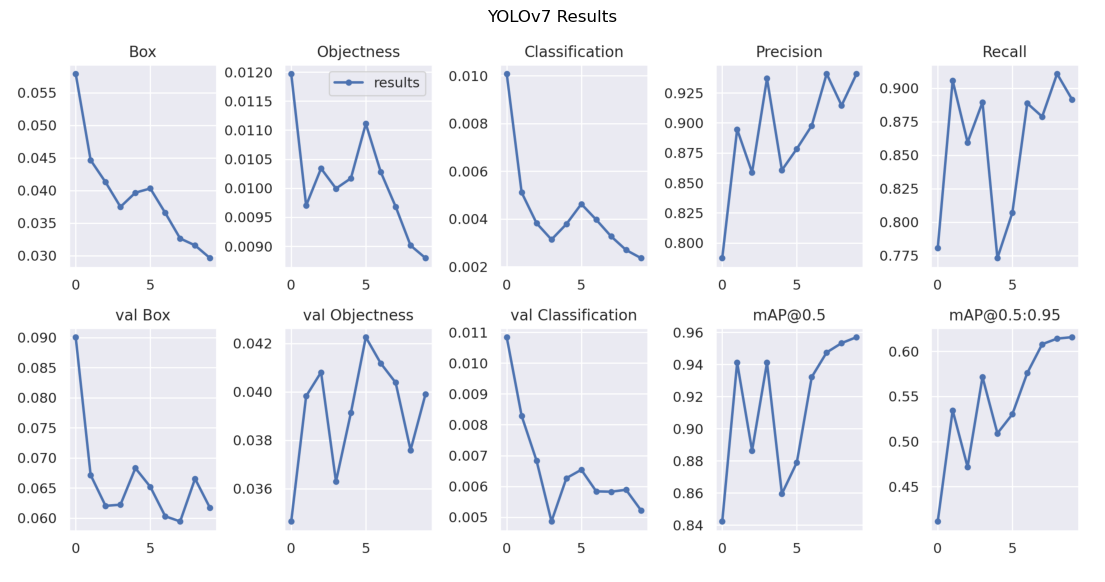

In [37]:
# path to your results.png
img = mpimg.imread("runs/train/exp7/results.png")
plt.figure(figsize=(14, 8))
plt.imshow(img)
plt.axis("off")         # removes axes
plt.title("YOLOv7 Results")
plt.show()


### 6. Results and Discussion: 
- The results show a decrease in box, objectness and classification loss and indicate the model learning the more epochs the model underwent.
- We can see that both precision and recall values went upwards showing improved detection accuracy.
- Furthmore the mAP on both metrics showed the metrics converged on both sets of thresholds
- There are other notable metrics such as the confusion matrix which shows a clear separation between head and helmet classes, signifiying the clear distinction of both.

#### Practical Implications
- Given these results, we can see that if applied to a real world construction site, we can install a safety system that can automatically show/detect when workers wear a helmet or not.
- This will allow for real time detection hopefully reducing safety incidents and prevent injury and death in the construction site. 

##### Conclusion
- The trained YOLOv7 model shows high reliability in detecting helmets and heads, allowing fo AI-driven safety monitoring in construction sites, which can aid in the compliance of workplace safety and result in proactive safety enforcement in professional environments.